<a href="https://colab.research.google.com/github/evbevz/epoxy-supervisor/blob/main/EpoxyLevel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
try:
    import google.colab
    IS_COLAB_ENV = True
except:
    IS_COLAB_ENV = False
if IS_COLAB_ENV:
    %pip install ultralytics
    !git clone https://github.com/evbevz/epoxy-supervisor.git
    dirBase = '/content/drive/MyDrive/Colab Notebooks/'

    from google.colab import drive
    drive.mount('/content/drive/')
else:
    dirBase = '/home/nikolay/opencv/'
%cd "{dirBase}epoxy-supervisor/"

In [2]:
import epoxylib
import os
from ultralytics import YOLO

# Значение уверенности в правильности распознавания, ниже которого не будем считать, что точки определились правильно. Т.е. координаты такой точки будем считать ложными и точку игнорировать.
kptConfidence = 0.8 # Сейчас точки если и распознаются, то с уверенностью больше 0.9

# Калибровочный файл в котором хранятся уровни от 0 до 20мл. В виде координат X,Y центра эллипса поверхности эпоксидки на каждом уровне.
filenameAnnotation = dirBase + 'epoxy-supervisor/samples/EpoxyLevelCalibrate.annotations.xml'

# Файл весов обученной для распознавания модели
#filenameAIModel = dirBase + 'epoxy-supervisor/weights/epoxy-supervisor.20241228.best.pt'
#filenameAIModel = dirBase + 'epoxy-supervisor/weights/es.yolo11s-pose.20250121.epoch400.pt'
filenameAIModel = dirBase + 'epoxy-supervisor/weights/es.yolo11s-pose.20250213.best.pt'

# Изображение для предсказания уровня эпоксидки
#filenameInjectorCam = 'epoxy-supervisor/samples/fail01.png'
#filenameInjectorCam = 'epoxy-supervisor/samples/000030.png'
#filenameInjectorCam20 = dirBase + 'epoxy-supervisor/samples/20ml.png'
#filenameInjectorCam18 = dirBase + 'epoxy-supervisor/samples/18ml.png'
#filenameInjectorCam10 = dirBase + 'epoxy-supervisor/samples/10ml.png'
#filenameInjectorCam0 = dirBase + 'epoxy-supervisor/samples/fail01.png'
#filenameInjectorCam = dirBase + 'epoxy-supervisor/frames-009/00900040.png'
#filenameInjectorCam1 = dirBase + 'epoxy-supervisor/lvl-test/frames/lvl-01803.png' #3.83
#filenameInjectorCam2 = dirBase + 'epoxy-supervisor/lvl-test/frames/lvl-02211.png' #2.31
#filenameInjectorCam3 = dirBase + 'epoxy-supervisor/lvl-test/frames/lvl-02212.png' #None

# Калибруем шприц
arrayEpoxyLevel = epoxylib.Calibrate(filenameAnnotation)

# Загружаем модель
model = YOLO(filenameAIModel)

# Запрос уровня по изображению
#level = 20
#level = epoxylib.GetEpoxyLevel(model, arrayEpoxyLevel, filenameInjectorCam, kptConfidence, level)
#print (f"Уровень эпоксидки: {level}")
#level = epoxylib.GetEpoxyLevel(model, arrayEpoxyLevel, filenameInjectorCam1, kptConfidence, 3.83)
#print (f"Уровень эпоксидки: {level}")
#level = epoxylib.GetEpoxyLevel(model, arrayEpoxyLevel, filenameInjectorCam2, kptConfidence, 2.31)
#print (f"Уровень эпоксидки: {level}")
#level = epoxylib.GetEpoxyLevel(model, arrayEpoxyLevel, filenameInjectorCam3, kptConfidence, None)
#print (f"Уровень эпоксидки: {level}")

In [3]:
# Постороения списка уровней по изображениям в папке
dataPath = dirBase + 'epoxy-supervisor/lvl-test/frames'
data = os.listdir(dataPath)
data.sort()
levels = []
index_with_none = []
level = 20
for i, file in enumerate(data):
    fullPath = f"{dataPath}/{file}"
    level = epoxylib.GetEpoxyLevel(model, arrayEpoxyLevel, fullPath , kptConfidence, level)
    levels.append(level)
    if level is not None:
        print (f"Файл: {file}. Уровень эпоксидки: {level:.2f}")
    else:
        index_with_none.append(i)
        print (f"Файл: {file}. УРОВЕНЬ ЭПОКСИДКИ: NONE !!!")

Файл: lvl-00001.png. Уровень эпоксидки: 20.00
Файл: lvl-00002.png. Уровень эпоксидки: 20.00
Файл: lvl-00003.png. Уровень эпоксидки: 20.00
Файл: lvl-00004.png. Уровень эпоксидки: 20.00
Файл: lvl-00005.png. Уровень эпоксидки: 20.00
Файл: lvl-00006.png. Уровень эпоксидки: 20.00
Файл: lvl-00007.png. Уровень эпоксидки: 20.00
Файл: lvl-00008.png. Уровень эпоксидки: 20.00
Файл: lvl-00009.png. Уровень эпоксидки: 20.00
Файл: lvl-00010.png. Уровень эпоксидки: 20.00
Файл: lvl-00011.png. Уровень эпоксидки: 20.00
Файл: lvl-00012.png. Уровень эпоксидки: 20.00
Файл: lvl-00013.png. Уровень эпоксидки: 20.00
Файл: lvl-00014.png. Уровень эпоксидки: 20.00
Файл: lvl-00015.png. Уровень эпоксидки: 20.00
Файл: lvl-00016.png. Уровень эпоксидки: 20.00
Файл: lvl-00017.png. Уровень эпоксидки: 20.00
Файл: lvl-00018.png. Уровень эпоксидки: 20.00
Файл: lvl-00019.png. Уровень эпоксидки: 20.00
Файл: lvl-00020.png. Уровень эпоксидки: 20.00
Файл: lvl-00021.png. Уровень эпоксидки: 20.00
Файл: lvl-00022.png. Уровень эпокс

In [4]:
for i in index_with_none:
    print (f"Индекс: {i},\tФайл: {data[i]}. УРОВЕНЬ ЭПОКСИДКИ: NONE !!!")
    levels[i] = 0

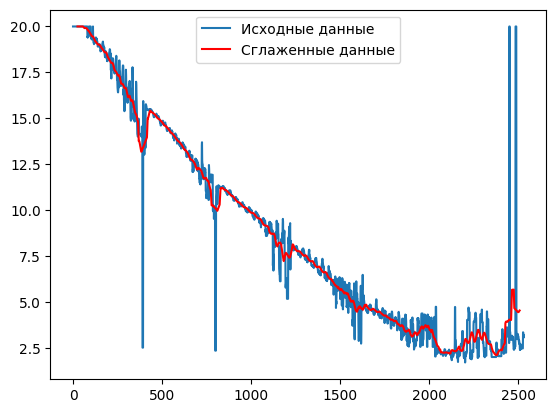

In [5]:
# https://www.delftstack.com/howto/python/smooth-data-in-python/
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pandas as pd

# Применение фильтра Савицкого-Голея для сглаживания
#levels_savgol = savgol_filter(levels, 11, 3)
levels_savgol = savgol_filter(levels, 50, 3)

# Метод скользящего среднего
# Простой и проверенный метод сглаживания — скользящее среднее. Он балансирует между скоростью вычислений и точностью границ данных.
# Использование функции np.cumsum для подсчёта скользящего среднего обеспечивает быстроту, но может приводить к краевым эффектам.
# Метод np.convolve с параметром mode='same' предотвращает изменение размера массива и позволяет сравнить сглаженные данные с исходными.
levels_cumsum = np.cumsum(levels)
levels_convolve = np.convolve(levels,1,mode='same')

#
levels_pd = pd.Series(levels).rolling(window=50, center=True).mean()

#from operator import sub
#delta = map(sub,levels,levels_pd)
delta = np.array(levels) - np.array(levels_pd)

plt.plot(levels, label='Исходные данные')
plt.plot(levels_pd, color='red', label='Сглаженные данные')
#plt.plot(delta, color='green', label='Разница от среднего')
plt.legend()
plt.show()

In [ ]:
#@title Make video
#!ffmpeg -threads auto -hwaccel cuda -y -framerate 5 -i {dirBase}epoxy-supervisor/runs/pose/predict/lvl-%5d.jpg -c:v h264_nvenc {dirBase}epoxy-supervisor/lvl-test.output.es20250213.mp4